In [190]:
import fiona
import numpy as np
import pandas as pd
import panel_processing as pp
import rendering

%load_ext autoreload
%autoreload 2

rendering.set_up()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


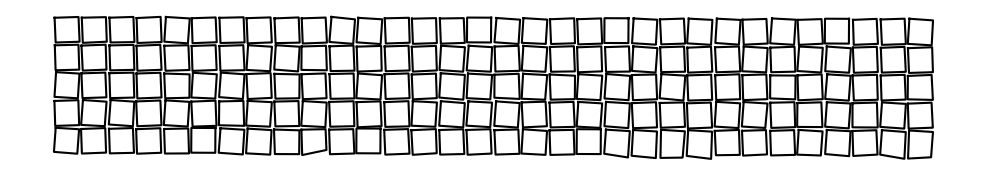

In [191]:
baseline_filename = 'qgis_assets/modulos_automatico_final_new_fixed.shp'
static_filename = 'qgis_assets/modulos_manual_fixed_geometry_new.shp'

shp, _, _ = pp.load_panels(static_filename, rendering=False)
_, norm_x = pp.name_panels(shp, clustering_distance=3)
shp, baseline_panels, _ = pp.load_panels(baseline_filename, rendering=False)
baseline_panels, _ = pp.name_panels(shp, clustering_distance=3)

# Filter panels in array 11
baseline_panels = [panel for panel in baseline_panels if panel.id_array == 11]
rendering.plot_rotated_panels(baseline_panels, norm_x=[norm_x[1], -norm_x[0]], savefig='results/test_automatic.png')

In [192]:
def fix_installation(missing_panels_percentage):
    shp, panels, clusters = pp.load_panels(baseline_filename, rendering=False)
    panels, norm_x = pp.name_panels(shp, clustering_distance=3)

    panels = pp.stress_missing_panels(panels, clusters, nrows=0, missing_panels_p=missing_panels_percentage / 100.0)
    panels = [panel for panel in panels if panel is not None]
    pp.write_panels(baseline_filename.split('.')[0] + '_new.shp', shp, panels)

    shp, panels, clusters = pp.load_panels(baseline_filename.split('.')[0] + '_new.shp', rendering=False)
    panels, _ = pp.name_panels(shp, clustering_distance=3, norm_x=norm_x)
    pp.write_panels(baseline_filename.split('.')[0] + '_new.shp', shp, panels)

    shp, panels, clusters = pp.load_panels(baseline_filename.split('.')[0] + '_new.shp', rendering=False)
    panels = pp.fill_panels(panels, clusters)
    panels = pp.remove_repeated_panels(panels)
    pp.write_panels(baseline_filename.split('.')[0] + '_new.shp', shp, panels)

    shp, _, _ = pp.load_panels(baseline_filename.split('.')[0] + '_new.shp', rendering=False)
    panels, _ = pp.name_panels(shp, clustering_distance=3, norm_x=norm_x)
    pp.write_panels(baseline_filename.split('.')[0] + '_' + str(missing_panels_percentage) + '.shp', shp, panels)
    rendering.plot_panels(panels, color_code=[panel.id_array for panel in panels], draw_text=True, draw_legend=False,
                          savefig='results/test.png')

    return panels

In [193]:
for missing_panels_percentage in range(10, 11, 1):
    print('Current missing panels percentage: ' + str(missing_panels_percentage))

    fix_installation(missing_panels_percentage)

Current missing panels percentage: 10


KeyboardInterrupt: 

In [ ]:
baseline_panels_centroid = dict()
for panel in baseline_panels:
    baseline_panels_centroid[panel.id_panel] = panel.centroid

percentage_distance = []

for missing_panels_percentage in range(0, 30, 1):
    _, panels, _ = pp.load_panels(baseline_filename.split('.')[0] + '_' + str(missing_panels_percentage) + '.shp', rendering=False)

    panels_centroid = dict()
    for panel in panels:
        panels_centroid[panel.id_panel] = panel.centroid

    # Compute distance between panels
    distance = 0
    for panel_id in baseline_panels_centroid.keys():
        if panel_id in panels_centroid.keys():
            # Compute rmse
            distance += np.sqrt((baseline_panels_centroid[panel_id][0] - panels_centroid[panel_id][0])**2 + (baseline_panels_centroid[panel_id][1] - panels_centroid[panel_id][1])**2)

    percentage_distance.append(distance / len(baseline_panels_centroid.keys()))
    print('Current distance: ' + str(percentage_distance[-1]))

# Fix anomalous values
for i in range(1, len(percentage_distance) - 1):
    if percentage_distance[i] > percentage_distance[i + 1]:
        percentage_distance[i] = (percentage_distance[i - 1] + percentage_distance[i + 1]) / 2.0

In [ ]:
# Plot
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(7, 4))
plt.plot(range(0, 30, 1), percentage_distance)
plt.xlabel('Missing panels percentage')
plt.ylabel('Distance between centroids (RMSE)')
# Plot lineal regression
reg = LinearRegression().fit(np.array(range(0, 30, 1)).reshape(-1, 1), np.array(percentage_distance).reshape(-1, 1))
plt.plot(range(0, 30, 1), reg.predict(np.array(range(0, 30, 1)).reshape(-1, 1)), color='red', linewidth=2, linestyle='--', alpha=0.2)
# Plot text every 5 points with only 2 decimals
for i in range(0, 30, 5):
    plt.text(i, percentage_distance[i] + 0.002, str(round(percentage_distance[i], 4)), fontsize=10, horizontalalignment='center', verticalalignment='center')
plt.tight_layout()
plt.savefig('results/centroid_distance.png', dpi=500)
plt.show()

In [ ]:
# Another test
panels = fix_installation(9)
panels = [panel for panel in panels if panel.id_array == 11]

In [ ]:
import math
import seaborn as sns

# Calculate centroid distance from panels to baseline panels
baseline_panels_centroid = dict()
for panel in baseline_panels:
    baseline_panels_centroid[panel.id_panel] = panel.centroid

panels_centroid = dict()
for panel in panels:
    panels_centroid[panel.id_panel] = panel.centroid

# Compute distance between panels
distance = dict()
for panel_id in panels_centroid.keys():
    if panel_id in baseline_panels_centroid.keys():
        # Compute rmse
        distance[panel_id] = np.sqrt((baseline_panels_centroid[panel_id][0] - panels_centroid[panel_id][0])**2 + (baseline_panels_centroid[panel_id][1] - panels_centroid[panel_id][1])**2)

distance_color = [distance[panel.id_panel] for panel in panels]
min_distance = 0.0
max_distance = 0.4
distance_color = [(color - min_distance) / (max_distance - min_distance) for color in distance_color]
# Generate color palette from indices
palette = np.array(sns.color_palette("inferno", 20))
print(palette)
# Create a color mapping from the palette
distance_color = [palette[int(math.floor(color * 19))] for color in distance_color]

In [ ]:
rendering.plot_rotated_panels(panels, norm_x=[norm_x[1], -norm_x[0]], norm_color=distance_color, savefig='results/test_automatico_10.png')

In [ ]:
shp, _, _ = pp.load_panels(static_filename, rendering=False)
_, norm_x = pp.name_panels(shp, clustering_distance=3)
shp, baseline_panels, _ = pp.load_panels(baseline_filename, rendering=False)
baseline_panels, _ = pp.name_panels(shp, clustering_distance=3)
baseline_panels = [panel for panel in baseline_panels if panel.id_array == 11]

for (idx, panel) in enumerate(baseline_panels):
    for (point_idx, point) in enumerate(baseline_panels[idx].geometry):
        current_x, current_y = point[0] * norm_x[0] + point[1] * norm_x[1], -point[0] * norm_x[1] + point[1] * \
                               norm_x[0]

        baseline_panels[idx].geometry[point_idx] = (current_x, current_y)
# # Filter panels in array 11
# baseline_panels = [panel for panel in baseline_panels if panel.id_array == 11]
# rendering.plot_rotated_panels(baseline_panels, norm_x=[norm_x[1], -norm_x[0]], savefig='results/test_automatic.png')

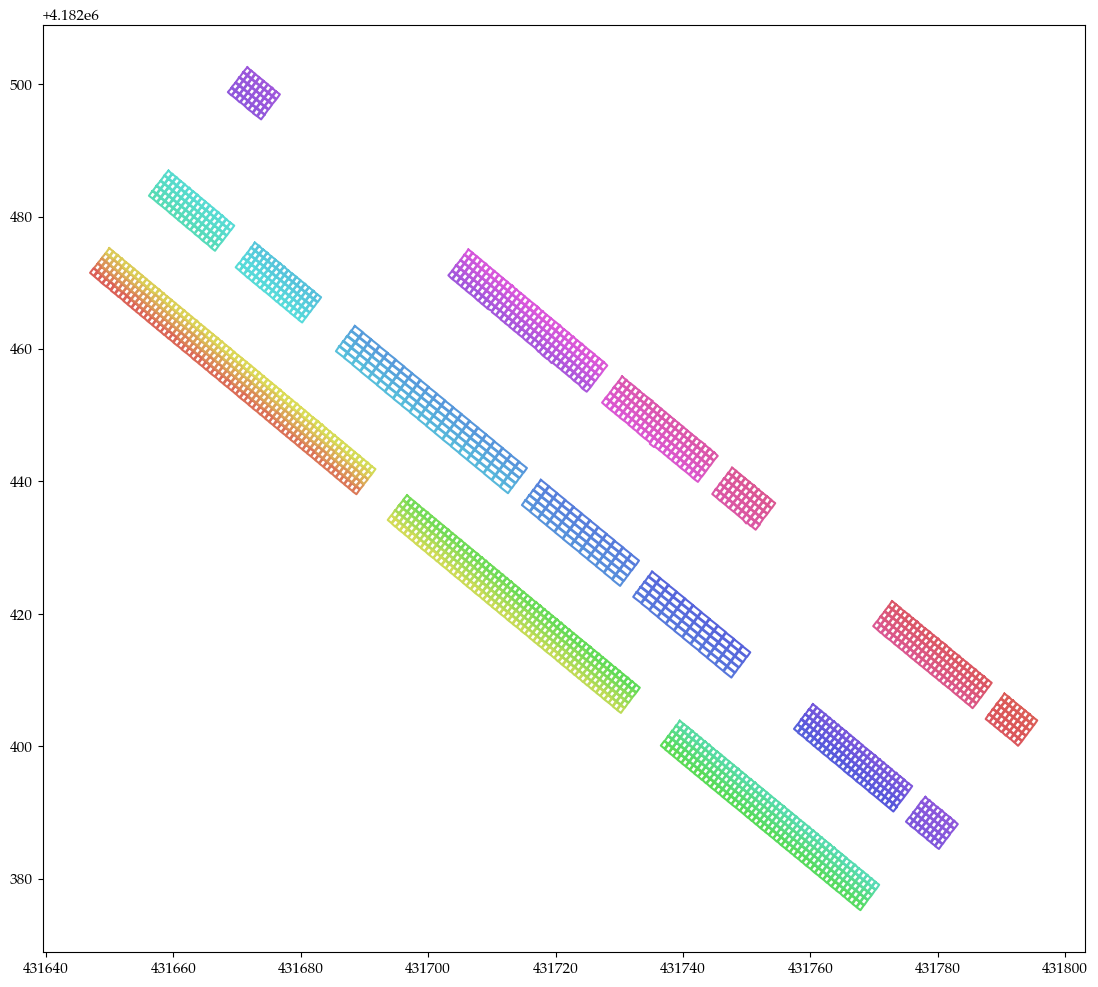

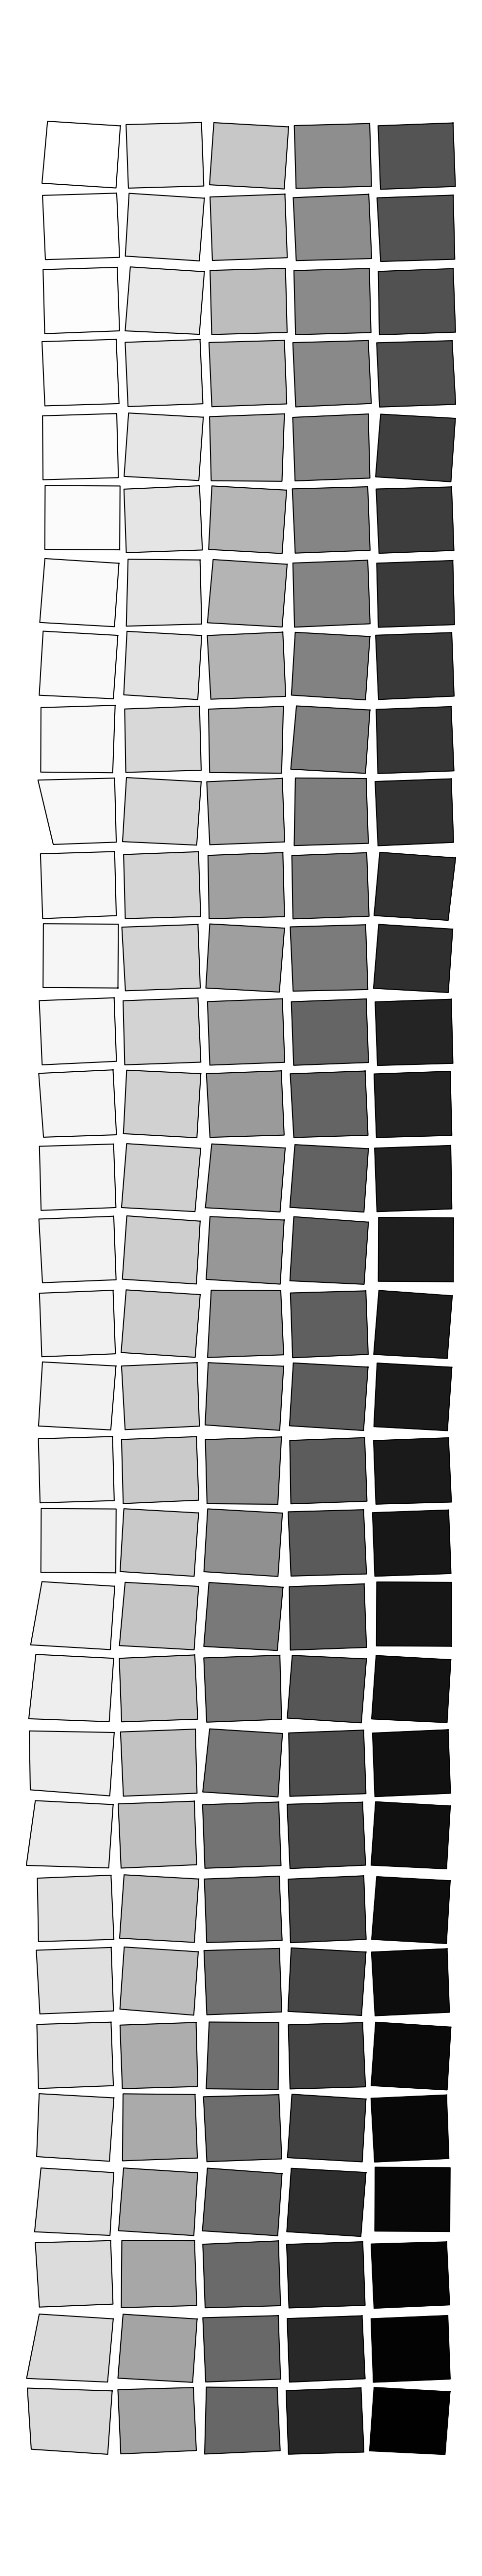

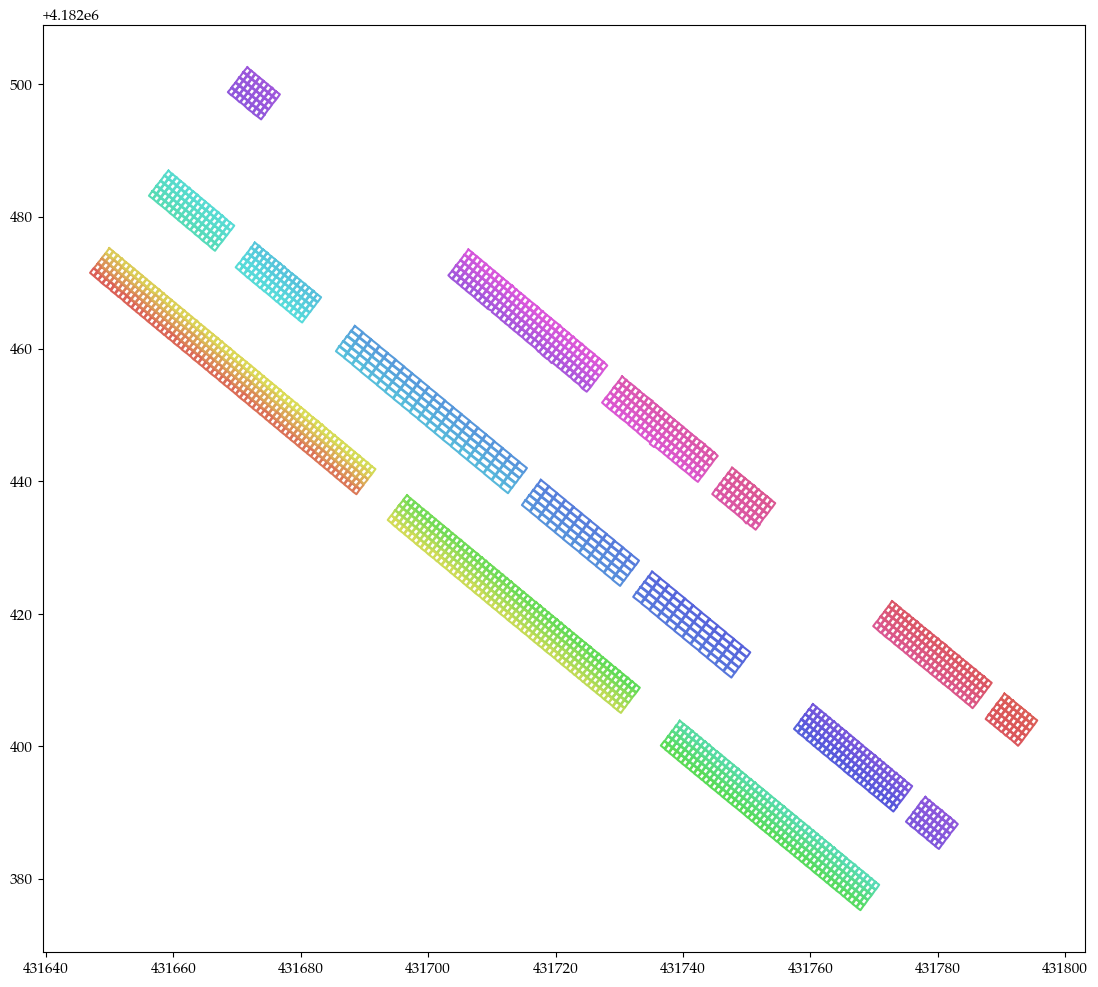

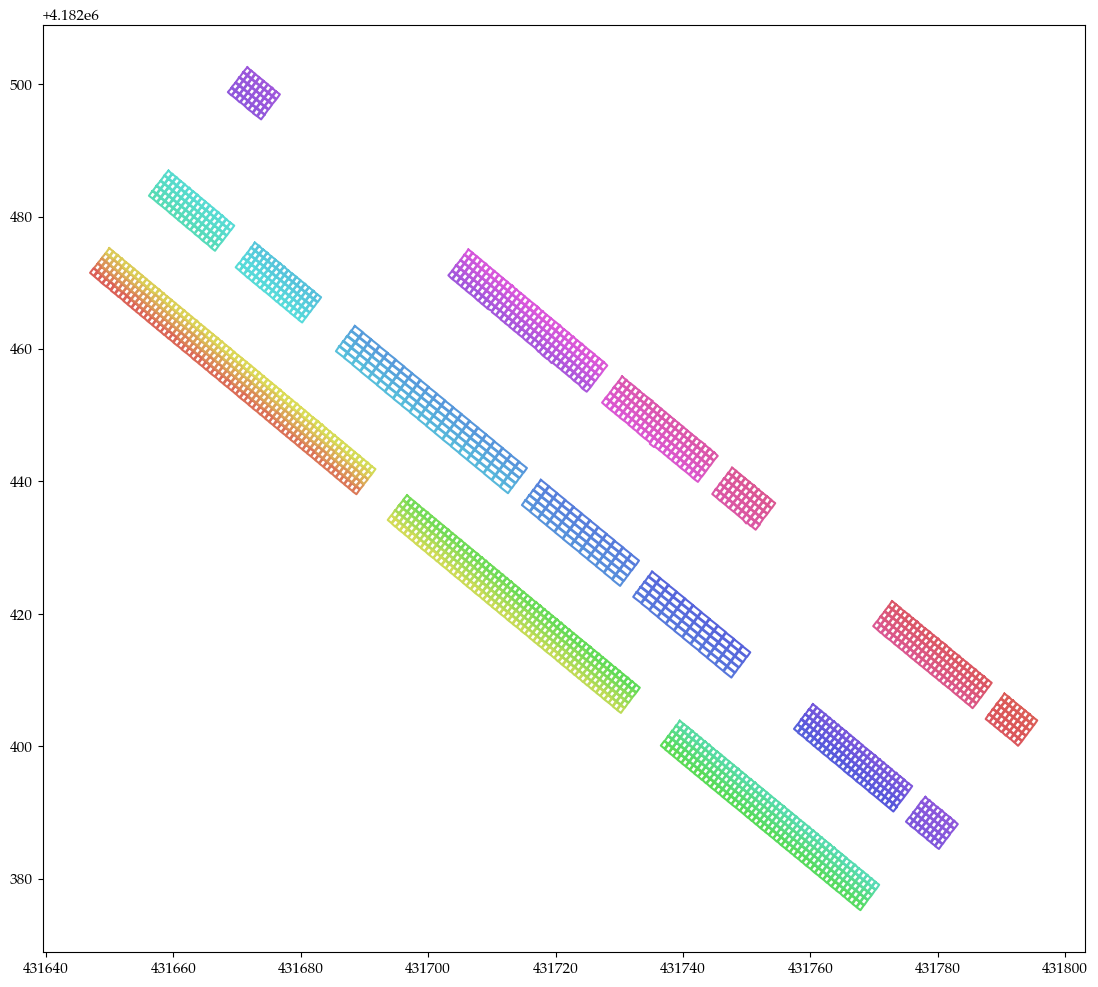

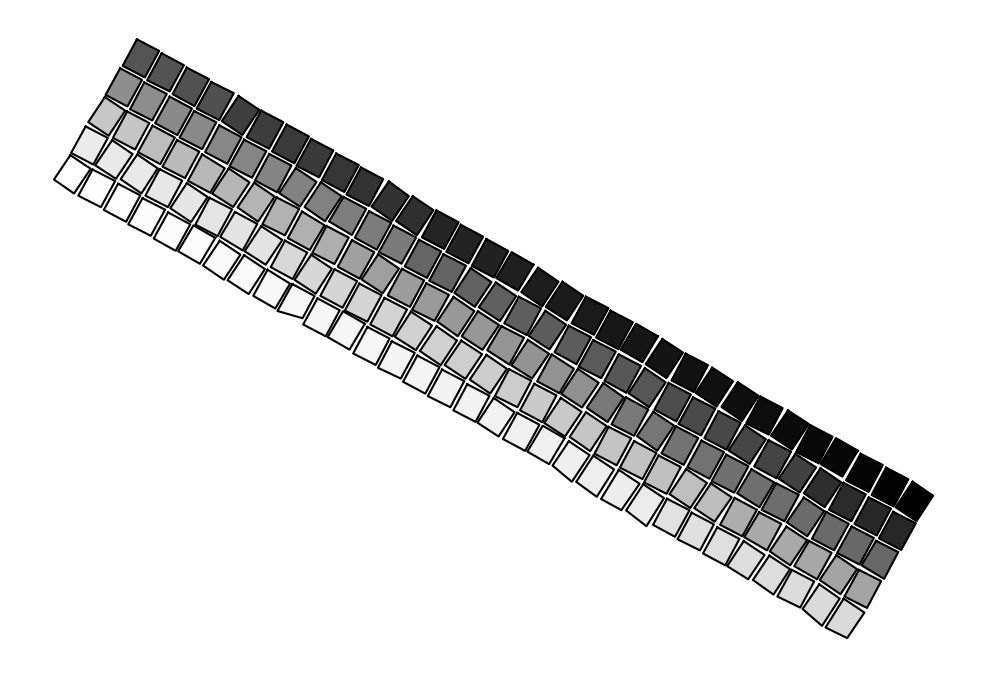

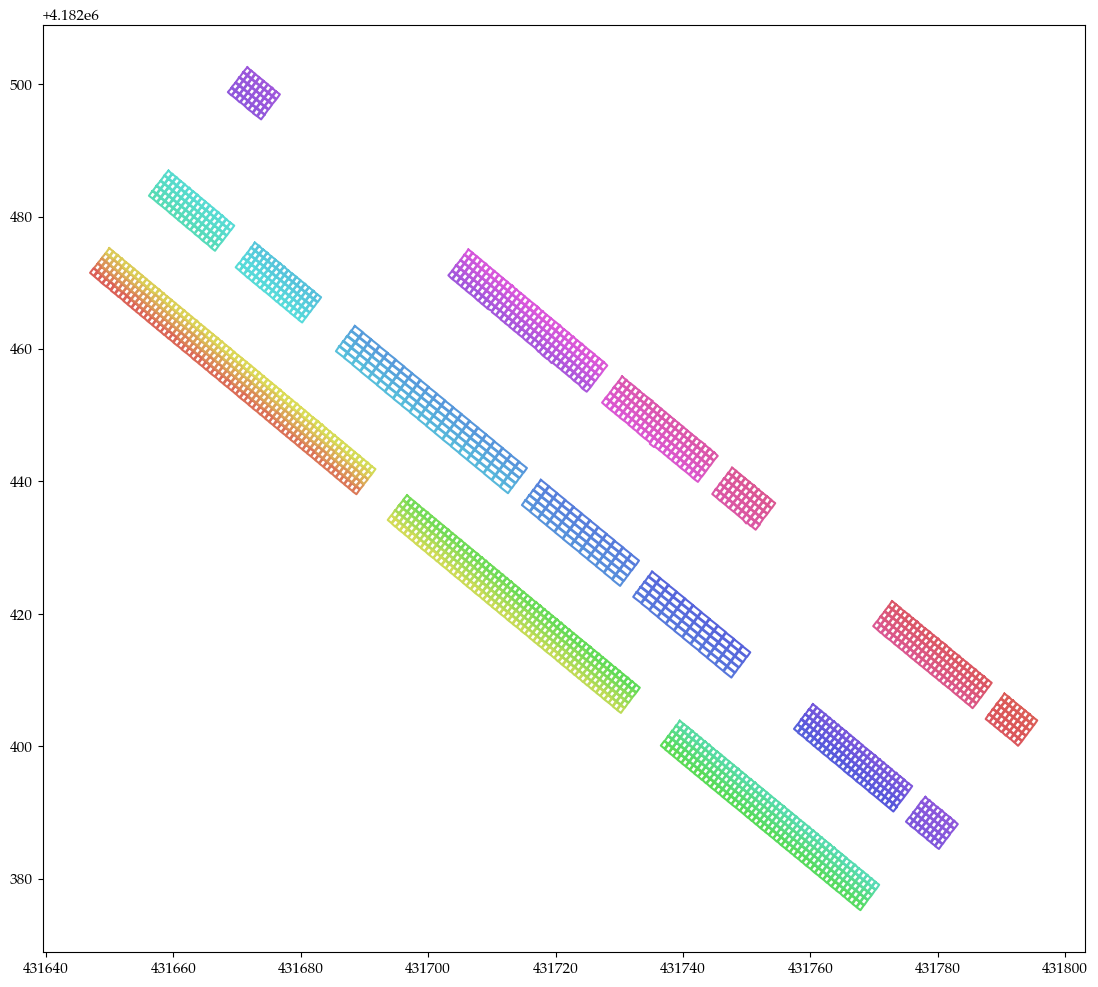

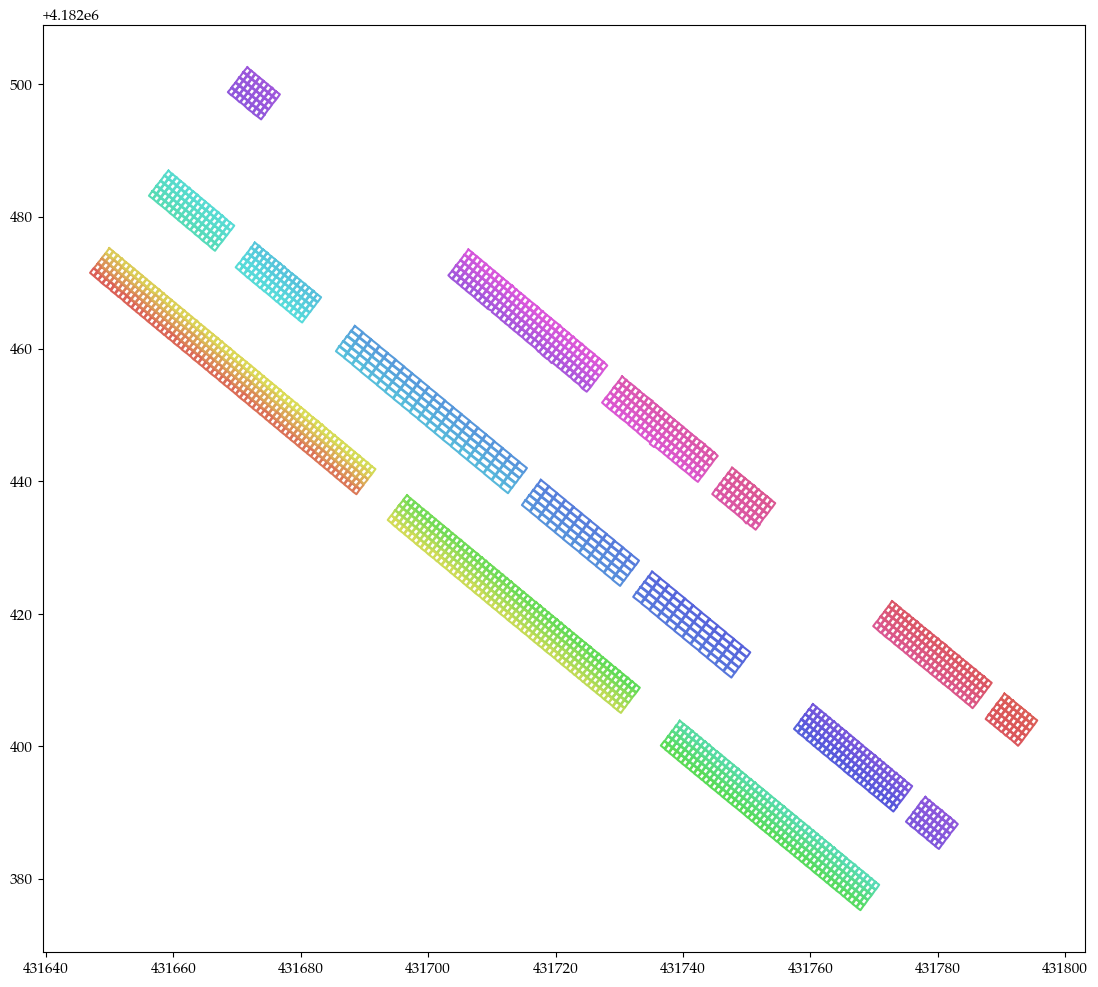

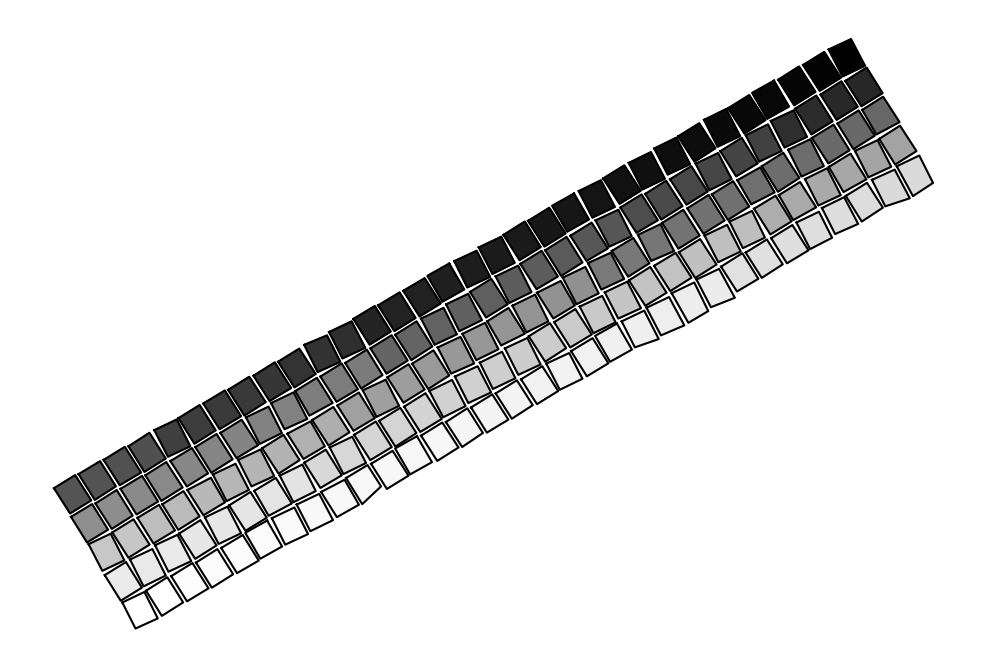

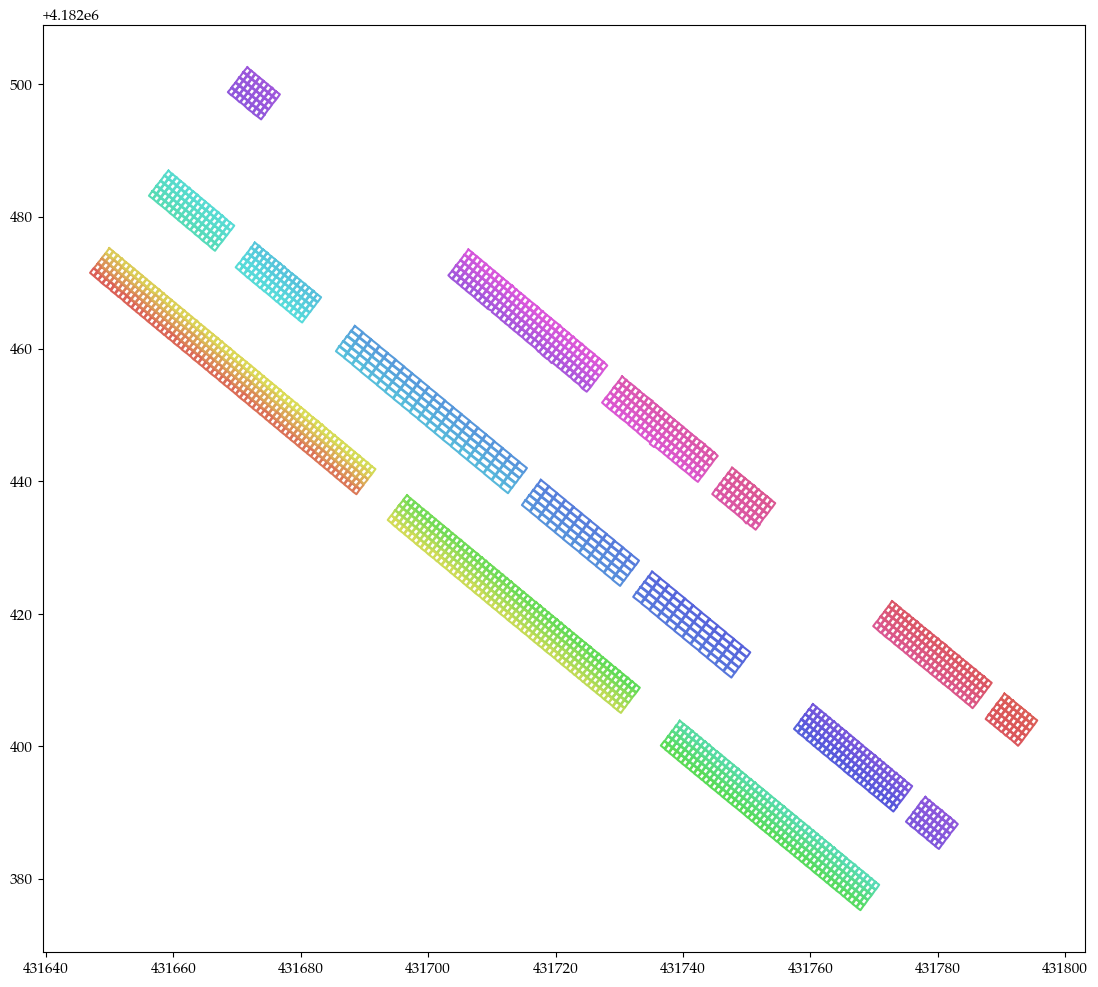

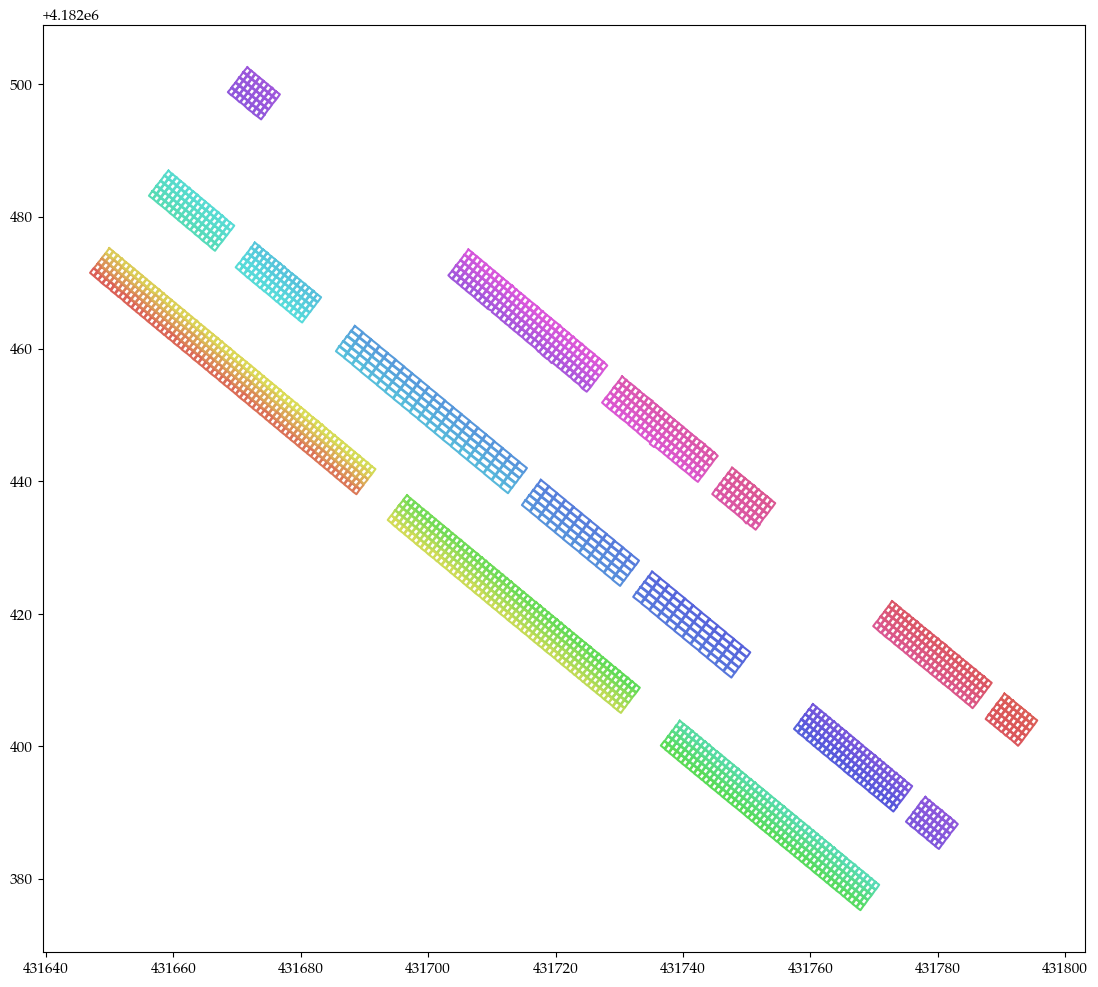

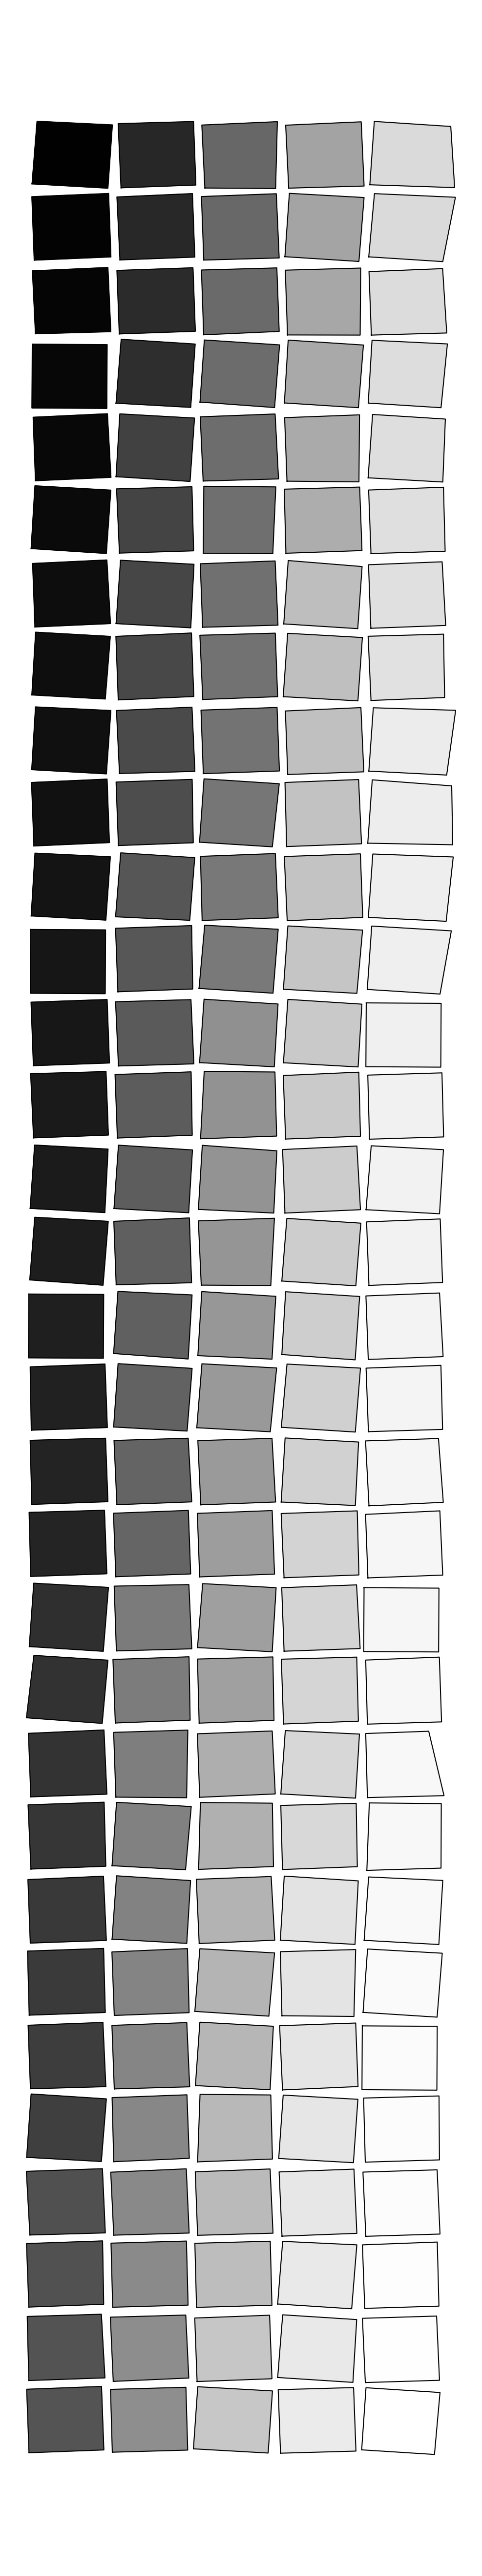

In [195]:
# Rotate around y axis from 0 to pi
import numpy as np

shp, _, _ = pp.load_panels(static_filename, rendering=False)
_, norm_x = pp.name_panels(shp, clustering_distance=3)
norm_x = [norm_x[1], -norm_x[0]]

for angle in np.arange(-np.pi / 2.0, np.pi / 2.0 + 0.0001, np.pi / 6):
    # Create copy of panels
    shp, baseline_panels, _ = pp.load_panels(baseline_filename, rendering=False)
    baseline_panels, _ = pp.name_panels(shp, clustering_distance=3)
    rendering.plot_panels(baseline_panels, color_code=[panel.id_panel for panel in baseline_panels], draw_text=False, draw_legend=False,
                          savefig='results/test.png')
    baseline_panels = [panel for panel in baseline_panels if panel.id_array == 11]

    for (idx, panel) in enumerate(baseline_panels):
        for (point_idx, point) in enumerate(baseline_panels[idx].geometry):
            current_x, current_y = point[0] * norm_x[0] + point[1] * norm_x[1], -point[0] * norm_x[1] + point[1] * \
                                   norm_x[0]

            baseline_panels[idx].geometry[point_idx] = (current_x, current_y)

    global_centroid = np.array([0, 0], dtype=np.float64)
    for panel in baseline_panels:
        global_centroid += panel.centroid
    global_centroid = global_centroid / len(baseline_panels)

    for (idx, panel) in enumerate(baseline_panels):
        # Rotate around global centroid
        for (point_idx, point) in enumerate(baseline_panels[idx].geometry):
            current_x, current_y = point[0] - global_centroid[0], point[1] - global_centroid[1]
            current_x, current_y = current_x * np.cos(angle) - current_y * np.sin(angle), current_x * np.sin(angle) + current_y * np.cos(angle)
            current_x, current_y = current_x + global_centroid[0], current_y + global_centroid[1]

            baseline_panels[idx].geometry[point_idx] = (current_x, current_y)

    pp.write_panels(baseline_filename.split('.')[0] + '_array_naming.shp', shp, baseline_panels)

    shp, baseline_panels, _ = pp.load_panels(baseline_filename.split('.')[0] + '_array_naming.shp', rendering=False)
    baseline_panels, _ = pp.name_panels(shp, clustering_distance=3)

    min_id_panel = min([panel.id_panel for panel in baseline_panels])
    max_id_panel = max([panel.id_panel for panel in baseline_panels]) - min_id_panel + 1

    for (idx, panel) in enumerate(baseline_panels):
        baseline_panels[idx].id_panel = baseline_panels[idx].id_panel - min_id_panel

    # Color encoding
    palette = np.array(sns.color_palette("Greys", max_id_panel))
    distance_color = [panel.id_panel for panel in baseline_panels]
    distance_color = [palette[int(color)] for color in distance_color]

    rendering.plot_rotated_panels(baseline_panels, norm_x=[1, 0], norm_color=distance_color, savefig='results/test_naming_' + str(angle) + '.png')